# Things are getting deep and convoluted
One trick that we haven't tried yet is the use of [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) layers. 

So far, we have always fed the board state into the Neural Network encoded as a 1D array. This makes it hard for the Neural Network to exploit the inherently 2D nature of a Tic Tac Toe board though.

CNN layers can slide a 2D window over an 2D input raster (+ an additional dimension for different channels, e.g. red, green, and blue colour channels in an image) and thus learn about inherently 2 dimensional patterns in the input:

<table width=80%> <tr> <td>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width="250" />
    </td><td>
<img src="https://cdn-images-1.medium.com/max/1600/0*iqNdZWyNeCr5tCkc." width="200" />
    </td></tr>
<tr> <td>
    [Source: Wikiepedia](https://en.wikipedia.org/wiki/File:Conv_layer.png)
    </td><td>
    [Source: Daphne Cornelisse "An intuitive guide to Convolutional Neural Networks"](https://medium.freecodecamp.org/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050)

</table>

And indeed, many contemporary NN approaches to learning how to play board games use CNN layers as part of their network topology. The most prominent example probably being [Alpha Go](https://deepmind.com/blog/alphago-zero-learning-scratch/) by Deep Mind. 


If it's good enough for them, it should be good enough for us. We'll take the NN from our previous part and simply pop a few CNN layers on top: 

```Python
def build_graph(self, name: str):
    """
    Builds a new TensorFlow graph with scope `name`
    :param name: The scope for the graph. Needs to be unique for the session.
    """
    with tf.variable_scope(name):
        [...]
        net = self.input_positions

        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=3,
                               kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(),
                               data_format="channels_last", padding='SAME', activation=tf.nn.relu)
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=3,
                               kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(),
                               data_format="channels_last", padding='SAME', activation=tf.nn.relu)
        net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=3,
                               kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(),
                               data_format="channels_last", padding='SAME', activation=tf.nn.relu)

        net = tf.layers.flatten(net)

        net = self.add_dense_layer(net, BOARD_SIZE * 3 * 9, tf.nn.relu)

```

We'll also have to change our input state encoding. The 2D part will be the 3x3 Tic Tac Toe board, and the channels will be the positions for CROSS, NAUGHT, and EMPTY.

I.e. our input will go from:
![Title](./Images/InputEncoding1D.PNG)

to
![Title](./Images/InputEncoding3D.PNG)

```Python
def board_state_to_nn_input(self, state: np.ndarray) -> np.ndarray:
    res = np.array([(state == self.side).astype(int),
                    (state == Board.other_side(self.side)).astype(int),
                    (state == EMPTY).astype(int)])
    res = res.reshape(3, 3, 3)
    res = np.transpose(res, [1, 2, 0])
```
The transpose at the end is necessary to switch the axis around and make the plane index be last index. It seems that TensorFlow likes it better this way - or in the case of running on a CPU actually insists. I.e., in theory `conv2d` has a parameter `data_format` where we could specify a different position for the channel index, in practice however, unless we run on a GPU, this will result in an "Not Implemented Exception".

By adding the `conv2d` layers we now have a Convolutional Neural Network. Since this also increases the depth of our network to more than 1 hidden layer, we can now also call it a Deep Network.


# Some other changes while we are at it
There are two more smaller changes we make at this stage. We add regularization loss and change some of the hyper-parameters a bit.

## Regularization Loss
One problem Neural Networks can face is that weights get increasingly large. This in turn can cause numerical instabilities. A straight forward approach to dealing with this, is to define a loss based on how large the weights are and add this to the total loss function of the Neural Network. This gives the training step an incentive to keep weights small. 

We need to balance the regularization loss with the rest of the loss function however to avoid the Neural Network optimizing the regularization loss at the expense of a higher loss in our Q function. We don't want this.

In the code this means, we add a `kernel_regularizer` to every layer, e.g. like this:

```Python
return tf.layers.dense(input_tensor, output_size, activation=activation_fn,
                       kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                       kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(),
                       name=name)
```

We then add the regularization loss to the total loss:

```Python
self.reg_losses = tf.identity(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, scope=name),
                              name="reg_losses")
reg_loss = self.beta * tf.reduce_mean(self.reg_losses)

self.total_loss = tf.add(self.loss, reg_loss, name="total_loss")
```
with `self.beta` being a factor smaller than 1 to scale down `reg_loss` and prevent it from dominating the optimization process.

## Some changes in hyper parameters

I have also changed some of the hyper-parameter:

```Python
def __init__(self, name: str, reward_discount: float = 0.99, win_value: float = 10.0, draw_value: float = 0.0,
                 loss_value: float = -10.0, learning_rate: float = 0.01, training: bool = True,
                 random_move_prob: float = 0.9999, random_move_decrease: float = 0.9997, batch_size=60,
                 pre_training_games: int = 500, tau: float = 0.001):
```

In particular, we do random moves for longer (with a reasonable chance of happening for the first 10,000 games), discount the reward less, and changed the win and loss rewards by a factor of 10.

The different reward is a puzzling one. As far as I understand the theory 1 to -1 should work better than 10 to -10. In our exampke however I found 10 to -10 to work much better. I'm not quite sure why that is.

# Let's play

Time to play some games. The player is implemented in [DeepExpDoubleDuelQPlayer](https://github.com/fcarsten/tic-tac-toe/blob/master/tic_tac_toe/DeepExpDoubleDuelQPlayer.py).

A note of warning: CNN performance really improves a lot by using a GPU. If you don't have a supported GPU and the GPU version of TensorFlow installed, you will need some patience.

To start with and to make sure we didn't break things, going first against the RandomPlayer:

After 100 game we have draws: 15, Player 1 wins: 56, and Player 2 wins: 29.
Which gives percentages of draws: 15.00%, Player 1 wins: 56.00%, and Player 2 wins:  29.00%
After 100 game we have draws: 13, Player 1 wins: 58, and Player 2 wins: 29.
Which gives percentages of draws: 13.00%, Player 1 wins: 58.00%, and Player 2 wins:  29.00%
After 100 game we have draws: 16, Player 1 wins: 58, and Player 2 wins: 26.
Which gives percentages of draws: 16.00%, Player 1 wins: 58.00%, and Player 2 wins:  26.00%
After 100 game we have draws: 12, Player 1 wins: 54, and Player 2 wins: 34.
Which gives percentages of draws: 12.00%, Player 1 wins: 54.00%, and Player 2 wins:  34.00%
After 100 game we have draws: 11, Player 1 wins: 61, and Player 2 wins: 28.
Which gives percentages of draws: 11.00%, Player 1 wins: 61.00%, and Player 2 wins:  28.00%
After 100 game we have draws: 9, Player 1 wins: 66, and Player 2 wins: 25.
Which gives percentages of draws: 9.00%, Player 1 wins: 66.00%, and Player 2 wins:  2

After 100 game we have draws: 3, Player 1 wins: 94, and Player 2 wins: 3.
Which gives percentages of draws: 3.00%, Player 1 wins: 94.00%, and Player 2 wins:  3.00%
After 100 game we have draws: 6, Player 1 wins: 91, and Player 2 wins: 3.
Which gives percentages of draws: 6.00%, Player 1 wins: 91.00%, and Player 2 wins:  3.00%
After 100 game we have draws: 2, Player 1 wins: 92, and Player 2 wins: 6.
Which gives percentages of draws: 2.00%, Player 1 wins: 92.00%, and Player 2 wins:  6.00%
After 100 game we have draws: 5, Player 1 wins: 91, and Player 2 wins: 4.
Which gives percentages of draws: 5.00%, Player 1 wins: 91.00%, and Player 2 wins:  4.00%
After 100 game we have draws: 4, Player 1 wins: 88, and Player 2 wins: 8.
Which gives percentages of draws: 4.00%, Player 1 wins: 88.00%, and Player 2 wins:  8.00%
After 100 game we have draws: 4, Player 1 wins: 91, and Player 2 wins: 5.
Which gives percentages of draws: 4.00%, Player 1 wins: 91.00%, and Player 2 wins:  5.00%
After 100 game w

After 100 game we have draws: 1, Player 1 wins: 95, and Player 2 wins: 4.
Which gives percentages of draws: 1.00%, Player 1 wins: 95.00%, and Player 2 wins:  4.00%
After 100 game we have draws: 0, Player 1 wins: 98, and Player 2 wins: 2.
Which gives percentages of draws: 0.00%, Player 1 wins: 98.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 1, Player 1 wins: 97, and Player 2 wins: 2.
Which gives percentages of draws: 1.00%, Player 1 wins: 97.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 7, Player 1 wins: 91, and Player 2 wins: 2.
Which gives percentages of draws: 7.00%, Player 1 wins: 91.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 3, Player 1 wins: 94, and Player 2 wins: 3.
Which gives percentages of draws: 3.00%, Player 1 wins: 94.00%, and Player 2 wins:  3.00%
After 100 game w

After 100 game we have draws: 0, Player 1 wins: 98, and Player 2 wins: 2.
Which gives percentages of draws: 0.00%, Player 1 wins: 98.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 2, Player 1 wins: 96, and Player 2 wins: 2.
Which gives percentages of draws: 2.00%, Player 1 wins: 96.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 1, Player 1 wins: 97, and Player 2 wins: 2.
Which gives percentages of draws: 1.00%, Player 1 wins: 97.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 98, and Player 2 wins: 1.
Which gives percentages of draws: 1.00%, Player 1 wins: 98.00%, and Player 2 wins:  1.00%
After 100 game

After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 ga

After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 ga

After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 

After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
Afte

After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 

After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 

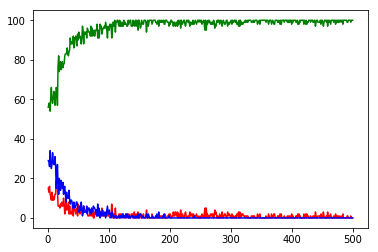

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

from util import evaluate_players
from tic_tac_toe.TFSessionManager import TFSessionManager
from tic_tac_toe.RandomPlayer import RandomPlayer
from tic_tac_toe.DeepExpDoubleDuelQPlayer import DeepExpDoubleDuelQPlayer

tf.reset_default_graph()

nnplayer = DeepExpDoubleDuelQPlayer("QLearner1")
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer, num_battles=500)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

I'm getting some really solid results here. In most cases for me, it even finds a policy that gives it 0% losses while still winning >98% of the games.

Let's try going second:

After 100 game we have draws: 12, Player 1 wins: 61, and Player 2 wins: 27.
Which gives percentages of draws: 12.00%, Player 1 wins: 61.00%, and Player 2 wins:  27.00%
After 100 game we have draws: 14, Player 1 wins: 58, and Player 2 wins: 28.
Which gives percentages of draws: 14.00%, Player 1 wins: 58.00%, and Player 2 wins:  28.00%
After 100 game we have draws: 13, Player 1 wins: 63, and Player 2 wins: 24.
Which gives percentages of draws: 13.00%, Player 1 wins: 63.00%, and Player 2 wins:  24.00%
After 100 game we have draws: 13, Player 1 wins: 63, and Player 2 wins: 24.
Which gives percentages of draws: 13.00%, Player 1 wins: 63.00%, and Player 2 wins:  24.00%
After 100 game we have draws: 8, Player 1 wins: 63, and Player 2 wins: 29.
Which gives percentages of draws: 8.00%, Player 1 wins: 63.00%, and Player 2 wins:  29.00%
After 100 game we have draws: 9, Player 1 wins: 60, and Player 2 wins: 31.
Which gives percentages of draws: 9.00%, Player 1 wins: 60.00%, and Player 2 wins:  31.

After 100 game we have draws: 12, Player 1 wins: 20, and Player 2 wins: 68.
Which gives percentages of draws: 12.00%, Player 1 wins: 20.00%, and Player 2 wins:  68.00%
After 100 game we have draws: 10, Player 1 wins: 17, and Player 2 wins: 73.
Which gives percentages of draws: 10.00%, Player 1 wins: 17.00%, and Player 2 wins:  73.00%
After 100 game we have draws: 9, Player 1 wins: 24, and Player 2 wins: 67.
Which gives percentages of draws: 9.00%, Player 1 wins: 24.00%, and Player 2 wins:  67.00%
After 100 game we have draws: 14, Player 1 wins: 13, and Player 2 wins: 73.
Which gives percentages of draws: 14.00%, Player 1 wins: 13.00%, and Player 2 wins:  73.00%
After 100 game we have draws: 4, Player 1 wins: 22, and Player 2 wins: 74.
Which gives percentages of draws: 4.00%, Player 1 wins: 22.00%, and Player 2 wins:  74.00%
After 100 game we have draws: 13, Player 1 wins: 20, and Player 2 wins: 67.
Which gives percentages of draws: 13.00%, Player 1 wins: 20.00%, and Player 2 wins:  67.

After 100 game we have draws: 8, Player 1 wins: 2, and Player 2 wins: 90.
Which gives percentages of draws: 8.00%, Player 1 wins: 2.00%, and Player 2 wins:  90.00%
After 100 game we have draws: 8, Player 1 wins: 4, and Player 2 wins: 88.
Which gives percentages of draws: 8.00%, Player 1 wins: 4.00%, and Player 2 wins:  88.00%
After 100 game we have draws: 11, Player 1 wins: 4, and Player 2 wins: 85.
Which gives percentages of draws: 11.00%, Player 1 wins: 4.00%, and Player 2 wins:  85.00%
After 100 game we have draws: 9, Player 1 wins: 3, and Player 2 wins: 88.
Which gives percentages of draws: 9.00%, Player 1 wins: 3.00%, and Player 2 wins:  88.00%
After 100 game we have draws: 12, Player 1 wins: 7, and Player 2 wins: 81.
Which gives percentages of draws: 12.00%, Player 1 wins: 7.00%, and Player 2 wins:  81.00%
After 100 game we have draws: 11, Player 1 wins: 1, and Player 2 wins: 88.
Which gives percentages of draws: 11.00%, Player 1 wins: 1.00%, and Player 2 wins:  88.00%
After 100 

After 100 game we have draws: 14, Player 1 wins: 0, and Player 2 wins: 86.
Which gives percentages of draws: 14.00%, Player 1 wins: 0.00%, and Player 2 wins:  86.00%
After 100 game we have draws: 5, Player 1 wins: 1, and Player 2 wins: 94.
Which gives percentages of draws: 5.00%, Player 1 wins: 1.00%, and Player 2 wins:  94.00%
After 100 game we have draws: 4, Player 1 wins: 0, and Player 2 wins: 96.
Which gives percentages of draws: 4.00%, Player 1 wins: 0.00%, and Player 2 wins:  96.00%
After 100 game we have draws: 11, Player 1 wins: 2, and Player 2 wins: 87.
Which gives percentages of draws: 11.00%, Player 1 wins: 2.00%, and Player 2 wins:  87.00%
After 100 game we have draws: 10, Player 1 wins: 1, and Player 2 wins: 89.
Which gives percentages of draws: 10.00%, Player 1 wins: 1.00%, and Player 2 wins:  89.00%
After 100 game we have draws: 7, Player 1 wins: 1, and Player 2 wins: 92.
Which gives percentages of draws: 7.00%, Player 1 wins: 1.00%, and Player 2 wins:  92.00%
After 100 

After 100 game we have draws: 6, Player 1 wins: 0, and Player 2 wins: 94.
Which gives percentages of draws: 6.00%, Player 1 wins: 0.00%, and Player 2 wins:  94.00%
After 100 game we have draws: 9, Player 1 wins: 0, and Player 2 wins: 91.
Which gives percentages of draws: 9.00%, Player 1 wins: 0.00%, and Player 2 wins:  91.00%
After 100 game we have draws: 6, Player 1 wins: 0, and Player 2 wins: 94.
Which gives percentages of draws: 6.00%, Player 1 wins: 0.00%, and Player 2 wins:  94.00%
After 100 game we have draws: 11, Player 1 wins: 1, and Player 2 wins: 88.
Which gives percentages of draws: 11.00%, Player 1 wins: 1.00%, and Player 2 wins:  88.00%
After 100 game we have draws: 8, Player 1 wins: 0, and Player 2 wins: 92.
Which gives percentages of draws: 8.00%, Player 1 wins: 0.00%, and Player 2 wins:  92.00%
After 100 game we have draws: 13, Player 1 wins: 0, and Player 2 wins: 87.
Which gives percentages of draws: 13.00%, Player 1 wins: 0.00%, and Player 2 wins:  87.00%
After 100 ga

After 100 game we have draws: 8, Player 1 wins: 0, and Player 2 wins: 92.
Which gives percentages of draws: 8.00%, Player 1 wins: 0.00%, and Player 2 wins:  92.00%
After 100 game we have draws: 4, Player 1 wins: 0, and Player 2 wins: 96.
Which gives percentages of draws: 4.00%, Player 1 wins: 0.00%, and Player 2 wins:  96.00%
After 100 game we have draws: 7, Player 1 wins: 0, and Player 2 wins: 93.
Which gives percentages of draws: 7.00%, Player 1 wins: 0.00%, and Player 2 wins:  93.00%
After 100 game we have draws: 6, Player 1 wins: 2, and Player 2 wins: 92.
Which gives percentages of draws: 6.00%, Player 1 wins: 2.00%, and Player 2 wins:  92.00%
After 100 game we have draws: 7, Player 1 wins: 0, and Player 2 wins: 93.
Which gives percentages of draws: 7.00%, Player 1 wins: 0.00%, and Player 2 wins:  93.00%
After 100 game we have draws: 6, Player 1 wins: 0, and Player 2 wins: 94.
Which gives percentages of draws: 6.00%, Player 1 wins: 0.00%, and Player 2 wins:  94.00%
After 100 game w

After 100 game we have draws: 8, Player 1 wins: 0, and Player 2 wins: 92.
Which gives percentages of draws: 8.00%, Player 1 wins: 0.00%, and Player 2 wins:  92.00%
After 100 game we have draws: 10, Player 1 wins: 0, and Player 2 wins: 90.
Which gives percentages of draws: 10.00%, Player 1 wins: 0.00%, and Player 2 wins:  90.00%
After 100 game we have draws: 15, Player 1 wins: 0, and Player 2 wins: 85.
Which gives percentages of draws: 15.00%, Player 1 wins: 0.00%, and Player 2 wins:  85.00%
After 100 game we have draws: 9, Player 1 wins: 1, and Player 2 wins: 90.
Which gives percentages of draws: 9.00%, Player 1 wins: 1.00%, and Player 2 wins:  90.00%
After 100 game we have draws: 9, Player 1 wins: 0, and Player 2 wins: 91.
Which gives percentages of draws: 9.00%, Player 1 wins: 0.00%, and Player 2 wins:  91.00%
After 100 game we have draws: 9, Player 1 wins: 0, and Player 2 wins: 91.
Which gives percentages of draws: 9.00%, Player 1 wins: 0.00%, and Player 2 wins:  91.00%
After 100 ga

After 100 game we have draws: 8, Player 1 wins: 0, and Player 2 wins: 92.
Which gives percentages of draws: 8.00%, Player 1 wins: 0.00%, and Player 2 wins:  92.00%
After 100 game we have draws: 8, Player 1 wins: 1, and Player 2 wins: 91.
Which gives percentages of draws: 8.00%, Player 1 wins: 1.00%, and Player 2 wins:  91.00%
After 100 game we have draws: 12, Player 1 wins: 1, and Player 2 wins: 87.
Which gives percentages of draws: 12.00%, Player 1 wins: 1.00%, and Player 2 wins:  87.00%
After 100 game we have draws: 11, Player 1 wins: 0, and Player 2 wins: 89.
Which gives percentages of draws: 11.00%, Player 1 wins: 0.00%, and Player 2 wins:  89.00%
After 100 game we have draws: 10, Player 1 wins: 0, and Player 2 wins: 90.
Which gives percentages of draws: 10.00%, Player 1 wins: 0.00%, and Player 2 wins:  90.00%
After 100 game we have draws: 3, Player 1 wins: 2, and Player 2 wins: 95.
Which gives percentages of draws: 3.00%, Player 1 wins: 2.00%, and Player 2 wins:  95.00%
After 100 

After 100 game we have draws: 5, Player 1 wins: 0, and Player 2 wins: 95.
Which gives percentages of draws: 5.00%, Player 1 wins: 0.00%, and Player 2 wins:  95.00%
After 100 game we have draws: 11, Player 1 wins: 0, and Player 2 wins: 89.
Which gives percentages of draws: 11.00%, Player 1 wins: 0.00%, and Player 2 wins:  89.00%
After 100 game we have draws: 5, Player 1 wins: 0, and Player 2 wins: 95.
Which gives percentages of draws: 5.00%, Player 1 wins: 0.00%, and Player 2 wins:  95.00%
After 100 game we have draws: 7, Player 1 wins: 0, and Player 2 wins: 93.
Which gives percentages of draws: 7.00%, Player 1 wins: 0.00%, and Player 2 wins:  93.00%
After 100 game we have draws: 6, Player 1 wins: 0, and Player 2 wins: 94.
Which gives percentages of draws: 6.00%, Player 1 wins: 0.00%, and Player 2 wins:  94.00%
After 100 game we have draws: 7, Player 1 wins: 0, and Player 2 wins: 93.
Which gives percentages of draws: 7.00%, Player 1 wins: 0.00%, and Player 2 wins:  93.00%
After 100 game

After 100 game we have draws: 10, Player 1 wins: 0, and Player 2 wins: 90.
Which gives percentages of draws: 10.00%, Player 1 wins: 0.00%, and Player 2 wins:  90.00%
After 100 game we have draws: 7, Player 1 wins: 0, and Player 2 wins: 93.
Which gives percentages of draws: 7.00%, Player 1 wins: 0.00%, and Player 2 wins:  93.00%
After 100 game we have draws: 8, Player 1 wins: 0, and Player 2 wins: 92.
Which gives percentages of draws: 8.00%, Player 1 wins: 0.00%, and Player 2 wins:  92.00%
After 100 game we have draws: 3, Player 1 wins: 0, and Player 2 wins: 97.
Which gives percentages of draws: 3.00%, Player 1 wins: 0.00%, and Player 2 wins:  97.00%
After 100 game we have draws: 8, Player 1 wins: 0, and Player 2 wins: 92.
Which gives percentages of draws: 8.00%, Player 1 wins: 0.00%, and Player 2 wins:  92.00%
After 100 game we have draws: 7, Player 1 wins: 0, and Player 2 wins: 93.
Which gives percentages of draws: 7.00%, Player 1 wins: 0.00%, and Player 2 wins:  93.00%
After 100 game

After 100 game we have draws: 19, Player 1 wins: 0, and Player 2 wins: 81.
Which gives percentages of draws: 19.00%, Player 1 wins: 0.00%, and Player 2 wins:  81.00%


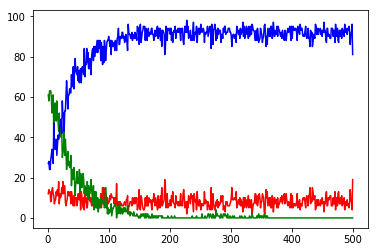

In [2]:
tf.reset_default_graph()

nnplayer = DeepExpDoubleDuelQPlayer("QLearner1")
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(rndplayer, nnplayer, num_battles=500)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

Now, we can't be unhappy about this. More than 90% wins and hardly any losses. 

Let's play the non-deterministic Min Max player. The NN player going first to start with:

After 100 game we have draws: 17, Player 1 wins: 0, and Player 2 wins: 83.
Which gives percentages of draws: 17.00%, Player 1 wins: 0.00%, and Player 2 wins:  83.00%
After 100 game we have draws: 24, Player 1 wins: 0, and Player 2 wins: 76.
Which gives percentages of draws: 24.00%, Player 1 wins: 0.00%, and Player 2 wins:  76.00%
After 100 game we have draws: 16, Player 1 wins: 0, and Player 2 wins: 84.
Which gives percentages of draws: 16.00%, Player 1 wins: 0.00%, and Player 2 wins:  84.00%
After 100 game we have draws: 22, Player 1 wins: 0, and Player 2 wins: 78.
Which gives percentages of draws: 22.00%, Player 1 wins: 0.00%, and Player 2 wins:  78.00%
After 100 game we have draws: 18, Player 1 wins: 0, and Player 2 wins: 82.
Which gives percentages of draws: 18.00%, Player 1 wins: 0.00%, and Player 2 wins:  82.00%
After 100 game we have draws: 16, Player 1 wins: 0, and Player 2 wins: 84.
Which gives percentages of draws: 16.00%, Player 1 wins: 0.00%, and Player 2 wins:  84.00%
Afte

After 100 game we have draws: 89, Player 1 wins: 0, and Player 2 wins: 11.
Which gives percentages of draws: 89.00%, Player 1 wins: 0.00%, and Player 2 wins:  11.00%
After 100 game we have draws: 87, Player 1 wins: 0, and Player 2 wins: 13.
Which gives percentages of draws: 87.00%, Player 1 wins: 0.00%, and Player 2 wins:  13.00%
After 100 game we have draws: 86, Player 1 wins: 0, and Player 2 wins: 14.
Which gives percentages of draws: 86.00%, Player 1 wins: 0.00%, and Player 2 wins:  14.00%
After 100 game we have draws: 85, Player 1 wins: 0, and Player 2 wins: 15.
Which gives percentages of draws: 85.00%, Player 1 wins: 0.00%, and Player 2 wins:  15.00%
After 100 game we have draws: 89, Player 1 wins: 0, and Player 2 wins: 11.
Which gives percentages of draws: 89.00%, Player 1 wins: 0.00%, and Player 2 wins:  11.00%
After 100 game we have draws: 88, Player 1 wins: 0, and Player 2 wins: 12.
Which gives percentages of draws: 88.00%, Player 1 wins: 0.00%, and Player 2 wins:  12.00%
Afte

After 100 game we have draws: 99, Player 1 wins: 0, and Player 2 wins: 1.
Which gives percentages of draws: 99.00%, Player 1 wins: 0.00%, and Player 2 wins:  1.00%
After 100 game we have draws: 96, Player 1 wins: 0, and Player 2 wins: 4.
Which gives percentages of draws: 96.00%, Player 1 wins: 0.00%, and Player 2 wins:  4.00%
After 100 game we have draws: 96, Player 1 wins: 0, and Player 2 wins: 4.
Which gives percentages of draws: 96.00%, Player 1 wins: 0.00%, and Player 2 wins:  4.00%
After 100 game we have draws: 98, Player 1 wins: 0, and Player 2 wins: 2.
Which gives percentages of draws: 98.00%, Player 1 wins: 0.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 98, Player 1 wins: 0, and Player 2 wins: 2.
Which gives percentages of draws: 98.00%, Player 1 wins: 0.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 95, Player 1 wins: 0, and Player 2 wins: 5.
Which gives percentages of draws: 95.00%, Player 1 wins: 0.00%, and Player 2 wins:  5.00%
After 100 game w

After 100 game we have draws: 99, Player 1 wins: 0, and Player 2 wins: 1.
Which gives percentages of draws: 99.00%, Player 1 wins: 0.00%, and Player 2 wins:  1.00%
After 100 game we have draws: 99, Player 1 wins: 0, and Player 2 wins: 1.
Which gives percentages of draws: 99.00%, Player 1 wins: 0.00%, and Player 2 wins:  1.00%
After 100 game we have draws: 98, Player 1 wins: 0, and Player 2 wins: 2.
Which gives percentages of draws: 98.00%, Player 1 wins: 0.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 98, Player 1 wins: 0, and Player 2 wins: 2.
Which gives percentages of draws: 98.00%, Player 1 wins: 0.00%, and Player 2 wins:  2.00%
After 100 game we have draws: 99, Player 1 wins: 0, and Player 2 wins: 1.
Which gives percentages of draws: 99.00%, Player 1 wins: 0.00%, and Player 2 wins:  1.00%
After 100 game we have draws: 99, Player 1 wins: 0, and Player 2 wins: 1.
Which gives percentages of draws: 99.00%, Player 1 wins: 0.00%, and Player 2 wins:  1.00%
After 100 game w

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 98, Player 1 wins: 0, and Player 2 wins: 2.
Which gives percentages of draws: 98.00%, Player 1 wins: 0.00%, and Player 2 wins:  2.00%
After 

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 99, Player 1 wins: 0, and Player 2 wins: 1.
Which gives percentages of draws: 99.00%, Player 1 wins: 0.00%, and Player 2 wins:  1.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

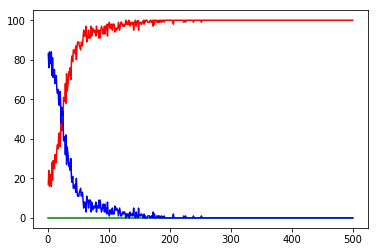

In [3]:
from tic_tac_toe.RndMinMaxAgent import RndMinMaxAgent

tf.reset_default_graph()

nnplayer = DeepExpDoubleDuelQPlayer("QLearner1")
rmm_player = RndMinMaxAgent()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rmm_player, num_battles=500)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

Still looking good. Somewhere between 200 and 300  battles it usually seems to find an optimal strategy. 

Now for the tricky one: Going against the non-deterministic Min Max Player going second:

After 100 game we have draws: 4, Player 1 wins: 96, and Player 2 wins: 0.
Which gives percentages of draws: 4.00%, Player 1 wins: 96.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 4, Player 1 wins: 96, and Player 2 wins: 0.
Which gives percentages of draws: 4.00%, Player 1 wins: 96.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 4, Player 1 wins: 96, and Player 2 wins: 0.
Which gives percentages of draws: 4.00%, Player 1 wins: 96.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game w

After 100 game we have draws: 57, Player 1 wins: 43, and Player 2 wins: 0.
Which gives percentages of draws: 57.00%, Player 1 wins: 43.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 50, Player 1 wins: 50, and Player 2 wins: 0.
Which gives percentages of draws: 50.00%, Player 1 wins: 50.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 60, Player 1 wins: 40, and Player 2 wins: 0.
Which gives percentages of draws: 60.00%, Player 1 wins: 40.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 60, Player 1 wins: 40, and Player 2 wins: 0.
Which gives percentages of draws: 60.00%, Player 1 wins: 40.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 58, Player 1 wins: 42, and Player 2 wins: 0.
Which gives percentages of draws: 58.00%, Player 1 wins: 42.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 67, Player 1 wins: 33, and Player 2 wins: 0.
Which gives percentages of draws: 67.00%, Player 1 wins: 33.00%, and Player 2 wins:  0.00%
Afte

After 100 game we have draws: 91, Player 1 wins: 9, and Player 2 wins: 0.
Which gives percentages of draws: 91.00%, Player 1 wins: 9.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 87, Player 1 wins: 13, and Player 2 wins: 0.
Which gives percentages of draws: 87.00%, Player 1 wins: 13.00%, and Player 2 wins:  0.00%
After 

After 100 game we have draws: 98, Player 1 wins: 2, and Player 2 wins: 0.
Which gives percentages of draws: 98.00%, Player 1 wins: 2.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 95, Player 1 wins: 5, and Player 2 wins: 0.
Which gives percentages of draws: 95.00%, Player 1 wins: 5.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 97, Player 1 wins: 3, and Player 2 wins: 0.
Which gives percentages of draws: 97.00%, Player 1 wins: 3.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 98, Player 1 wins: 2, and Player 2 wins: 0.
Which gives percentages of draws: 98.00%, Player 1 wins: 2.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 99, Player 1 wins: 1, and Player 2 wins: 0.
Which gives percentages of draws: 99.00%, Player 1 wins: 1.00%, and Player 2 wins:  0.00%
After 100 game

After 100 game we have draws: 99, Player 1 wins: 1, and Player 2 wins: 0.
Which gives percentages of draws: 99.00%, Player 1 wins: 1.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 98, Player 1 wins: 2, and Player 2 wins: 0.
Which gives percentages of draws: 98.00%, Player 1 wins: 2.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 99, Player 1 wins: 1, and Player 2 wins: 0.
Which gives percentages of draws: 99.00%, Player 1 wins: 1.00%, and Player 2 wins:  0.00%
After 100 

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

After 100 game we have draws: 99, Player 1 wins: 1, and Player 2 wins: 0.
Which gives percentages of draws: 99.00%, Player 1 wins: 1.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

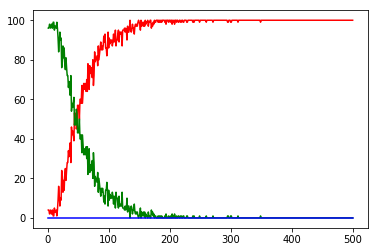

In [4]:
tf.reset_default_graph()

nnplayer = DeepExpDoubleDuelQPlayer("QLearner1")
rmm_player = RndMinMaxAgent()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(rmm_player, nnplayer, num_battles=500)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

Yeah! I ran this quite a couple of time and it doesn't always get to 100% in the end, but more often than not it does. Event when it does not it get's quite close.

I think we've got a wrap!

# Conclusion

How hard can it be to train a Neural Network to play Tic Tac Toe well? As we found out, harder than one would think. While even simple Neural Networks seems to be able to play better than random, mastering the game seems to be quite challangin for a Neural Net and we had to employ quite a large set of tricks and techniques to get there in the end. 

Now, unfortunately, I wasn't particularly patient and methodical. Instead of making one small change after the other we often added quite a few at a time. So we don't really know what did the trick in the end, and maybe most of what we did wasn't actually that important. I did however quite a bit of experimenting with other configurations, and I couldn't find any short-cuts that would produce reliable results. Feel encouraged to try yourself and report back if you have more luck.

The other thing is the huge number of hyper-parameters we ended up with in the end:

* Input (Game state) Encoding
* Learning rate
* Reward discount (gamma)
* Rewards for winning, losing, and draw
* Initial random move probability
* Decrease rate of random move probability
* Batch-size for experience replay
* Number of pre-training games
* Target network update rate (tau)
* Regularization loss scale factor (beta)
* Number of CNN layers
* Kernel size and number of filters for each CNN layer
* Number and size of fully connected layers
* Activation functions
* Optimizer method

All of these can be tuned, often with significant, and sometimes with surprising effect on the outcome. For each choice of hyper-parameters we need to run many iterations to get statistically significant results. Each run takes a significant amount of time. 

# Other things to try

I think I'm going to leave it there, ending on a high note. There are however some other approaches that one could try: 

Instead of learning the Q function, one could try to have the NN learn the policy directly similar to the approach in [Simple Reinforcement Learning with Tensorflow: Part 2 - Policy-based Agents](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724). 

One could also try an [Asynchronous Actor-Critic Agents](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-8-asynchronous-actor-critic-agents-a3c-c88f72a5e9f2) (A3C) approach which has good chances of working even better than our Deep Q Learning approach.

I might give this a try sometime in the future, or if you want to have a go at it, let us know how you went.